In [1]:
using CSV
using DataFrames
using Plots
using LinearAlgebra
using LaTeXStrings

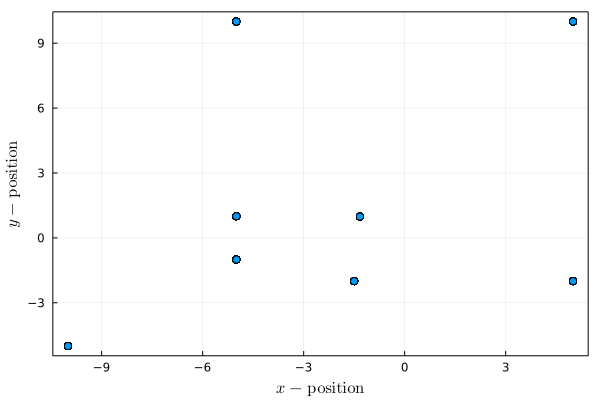

In [2]:
dubinsData = CSV.read("./DataFiles/dubinsOutCirc.csv", DataFrame)
size(dubinsData)
length(dubinsData.x)
fig1 = scatter(dubinsData.x_final, dubinsData.y_final, frame_style = :box, legend = false)
xlabel!(fig1, L"$x-\textrm{position}$")
ylabel!(fig1, L"$y-\textrm{position}$")
display(fig1)

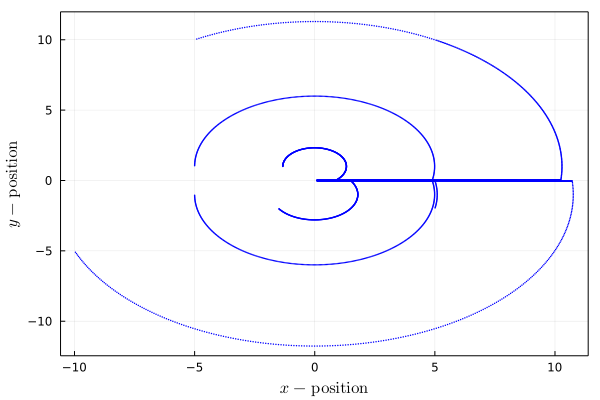

In [3]:
data = deepcopy(dubinsData)

round.(data.input)

function shift_rotate(x, y, x_shift, y_shift, θ_shift)
    v = [x - x_shift, y-y_shift]
    R = [cos(θ_shift) sin(θ_shift); -sin(θ_shift) cos(θ_shift)]
    vf = R*v
    return vf[1], vf[2]
end

tempX = zeros(length(data.x_final))
tempY = zeros(length(data.y_final))

for i=1:length(data.x_final)
    (tempX[i], tempY[i]) = shift_rotate(data.x_final[i], data.y_final[i],
                                                      data.x[i], data.y[i], data.theta[i])
end

data.x_final .= tempX
data.y_final .= tempY

data.x .= 0
data.y .= 0
data.theta .= 0
figOutCircDP = scatter(data.x_final, data.y_final, markersize = 1, color = :blue, msc=:blue, 
                       markershape = :circle, frame_style = :box, legend = false)
xlabel!(figOutCircDP, L"$x-\textrm{position}$")
ylabel!(figOutCircDP, L"$y-\textrm{position}$")
display(figOutCircDP)

In [4]:
# Remove most of the data on x-axis to make the dataset balanced
cond1 = (data.y_final .<= -0.05) .| (data.y_final .>= 0.05)  # Keep this data which is away from x-axis
cond2 = (collect(1:length(data.y_final))) .% 2000 .== 0  # Keep this data which is index less than 2000
cond3 = (data.input .!= 0) # Keep the data only if input is nonzero
dataX = data[(cond1 .| cond2) .& cond3,:]
scatter(dataX.x_final, dataX.y_final, markersize = 1, color = :black, msc=:black, markershape = :circle)
dataX[!,:input] .= Int64.(round.(dataX.input))
select!(dataX, [:x_final, :y_final, :input])
dataN = dataX[(dataX.input .!= 0),:]

,x_final,y_final,input
,Float64,Float64,Int64
1,-1.3301,0.996851,1
2,-1.33006,1.0101,1
3,-1.3299,1.02335,1
4,-1.3296,1.0366,1
5,-1.32916,1.04984,1
6,-1.3286,1.06308,1
7,-1.3279,1.07631,1
8,-1.32707,1.08954,1
9,-1.32611,1.10276,1


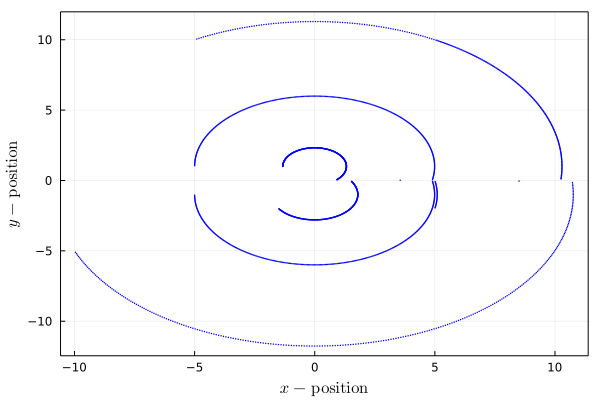

In [5]:
X = [dataN.x_final dataN.y_final]
y = dataN.input
figOutCircDPNZ =  scatter(dataN.x_final, dataN.y_final, markersize = 1, color = :blue, msc=:blue, 
                                markershape = :circle, frame_style = :box, legend = false)

xlabel!(figOutCircDPNZ, L"$x-\textrm{position}$")
ylabel!(figOutCircDPNZ, L"$y-\textrm{position}$")
display(figOutCircDPNZ)

In [6]:
using ScikitLearn
using ScikitLearn.CrossValidation: train_test_split
@sk_import tree: DecisionTreeClassifier
@sk_import preprocessing: StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

4-element Vector{Array}:
 [-1.4074331900793489 11.197214628738012; 1.3447872544313353 -2.188737237996282; … ; -1.326110630583555 1.1027554191567068; 0.8553350649608904 -2.5795059096592525]
 [8.204992922822115 7.208549567118622; -3.5909579938014238 -4.477193166188281; … ; 1.6082887758466105 -0.2047929534300079; -3.6255501322174672 4.44116032551629]
 [1, -1, 1, -1, 1, 1, -1, -1, -1, 1  …  -1, 1, 1, -1, 1, -1, -1, 1, 1, -1]
 [1, -1, 1, 1, 1, 1, 1, 1, 1, -1  …  -1, -1, 1, 1, -1, -1, 1, 1, -1, 1]

In [7]:
DTClassifier = DecisionTreeClassifier(max_depth =100,criterion="entropy")
dTree = DTClassifier.fit(X_train, y_train)
y_pred = dTree.predict(X_test)
dTree.predict([1 2])

# metrics are used to find accuracy or error
@sk_import metrics: accuracy_score  
print()
  
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL: 1.0

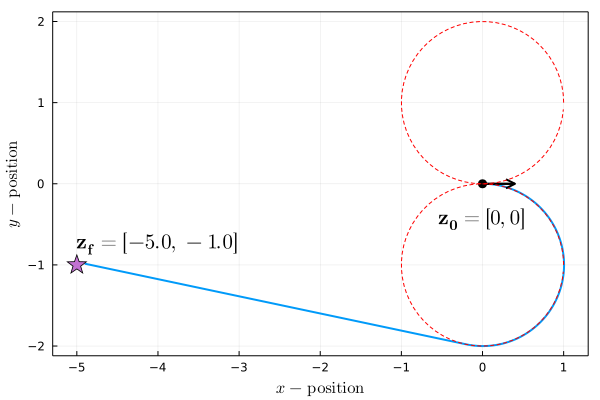

In [10]:
# Simulation using the learned model
dubins_dyn(x, u) = [cos(x[3]), sin(x[3]), u]
x0 = [0, 0, 0]
xf = [-5.0, -1]
n_iter = 1000
dt = 0.01

states = zeros(n_iter, 3)
input = zeros(n_iter)

states[1,:] .= x0
last_ind = 1
dubins_dyn(x0, 1)*dt
for i=1:n_iter-1
    x_tran = shift_rotate(xf[1], xf[2], states[i,1], states[i,2], states[i, 3])
    u = dTree.predict([x_tran[1] x_tran[2]])
    states[i+1,:] .= states[i,:] .+ dt*dubins_dyn(states[i,:], u[1])
    last_ind = i
    if norm(xf-states[i,1:2]) < 0.1
        break
    end
end

function plot_circle(xc, yc, rc, fig)
	th = collect(0:0.1:2π)
	plot!(fig, xc .+ rc*cos.(th), yc .+ rc*sin.(th), line =:dash, color =:red, label =nothing)
end

fig1 = plot(states[1:last_ind,1], states[1:last_ind,2], aspect_ratio = 1, frame_style = :box,
            legend = false, lw = 2)
# scatter!(fig1, [xf[1], x0[1]], [xf[2], x0[2]], ms = 7)
xlabel!(fig1, L"$x-\textrm{position}$")
ylabel!(fig1, L"$y-\textrm{position}$")
plot!(fig1, [0.0, 0.4], [0.0, 0.0], color =:black,arrow=true, arrowsize=1, lw=2, label =nothing)
scatter!(fig1, [0], [0], color =:black, markersize = 5, label =  nothing)
scatter!(fig1, [xf[1]], [xf[2]], shape = :star5, label = nothing, markersize = 10)
annotate!(fig1, 0.0, -0.4, L"$\mathbf{z_0} = [0, 0]$")
x_f = xf[1]; y_f = xf[2]
annotate!(fig1, xf[1]+1.0, xf[2]+0.3, L"$\mathbf{z_f} = [%$x_f, %$y_f]$")
plot_circle(0, 1.0, 1.0, fig1)
plot_circle(0, -1.0, 1.0, fig1)
display(fig1)
